In [1]:
import pandas as pd, numpy as np
import ast, gc, re, math

In [2]:
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/Users/irenaradzevich/Documents/sergei_dev/final project/'

## Read the DATA and clean some DATA structure

In [4]:
data = pd.read_csv(PATH+'data.csv')
data.shape

(377185, 18)

In [5]:
data = data[~pd.isna(data.target)]      # drop records without target's value

In [6]:
# clean vectors names as PEP8 (not exact:)
data.columns = [i.replace('.','_') for i in data.columns]
data.columns = [i.replace(' ','_') for i in data.columns]
data.columns = [i.replace('-','_') for i in data.columns]

In [7]:
# drop records witch are not house actually - only buildable plan
data_copy = data.copy()
data_copy.street.fillna('no data', inplace=True)
data_copy[data_copy.street.str.contains('Buildable plan')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,PrivatePool,MlsId,target
100,NaN,NaN,Single Family,Buildable plan: Coral Pine Lakes,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Jacksonville,"[{'rating': ['6/10', '4/10', '4/10'], 'data': ...","2,492",32218,4,FL,2,NaN,NaN,NaN,"$285,990"
292,NaN,NaN,Single Family,Buildable plan: Sabine Hidden Meadow - 40's,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '4/10', '2/10'], 'data': ...","1,844",77044,4,TX,NaN,NaN,NaN,NaN,"$182,490"
342,New construction,NaN,Single Family,Buildable plan: Residence 1945 Catalina at Wes...,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Sacramento,"[{'rating': ['3/10', '3/10', 'NA'], 'data': {'...","1,945",95834,4,CA,2,NaN,NaN,NaN,"$423,990"
421,New construction,NaN,Single Family,Buildable plan: Tiberon High Point,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['3/10', '6/10', '4/10'], 'data': ...","2,074",98126,4,WA,3,NaN,NaN,NaN,"$709,950"
555,NaN,NaN,Single Family,Buildable plan: The Westford Coronado,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,San Antonio,"[{'rating': ['8/10', '9/10', '9/10'], 'data': ...","3,143",78258,3,TX,2.0,NaN,NaN,NaN,"$412,900"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376713,NaN,NaN,Townhouse,Buildable plan: Camilla III Randal Walk,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Orlando,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...","1,602",32832,3,FL,NaN,NaN,NaN,NaN,"$274,390"
376869,New construction,NaN,Single Family,Buildable plan: The Woodland Savannah Highlands,2.5 ba,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Savannah,"[{'rating': ['5/10', '2/10'], 'data': {'Distan...","2,041 sqft",31407,3 bd,GA,NaN,NaN,NaN,NaN,"$238,900"
376953,New construction,NaN,Single Family,Buildable plan: Berkley Palmira Lakes,3 ba,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Fort Wayne,"[{'rating': ['6/10', '7/10', '9/10'], 'data': ...","2,562 sqft",46818,4 bd,IN,NaN,NaN,NaN,NaN,"$251,600"
377008,NaN,NaN,Single Family,Buildable plan: The Bowen Whisper Falls,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,San Antonio,"[{'rating': ['7/10', '5/10', '6/10'], 'data': ...","2,241",78252,3,TX,2.0,NaN,NaN,NaN,"$239,000"


In [8]:
data = data[~data_copy.street.str.contains('Buildable plan')] #2459
del data_copy
gc.collect()

106

In [9]:
# drop records without address street
data = data[~pd.isna(data.street)]  # 2
# drop records with street data as "'Address Not Disclosed", "Undisclosed Address", "Address Not Available"
data = data[~data.street.str.contains('Address')]  #1668

# drop records of 'Land' type. It is not house
data = data[data.propertyType != 'Land'] #~10K

In [10]:
data.shape

(359522, 18)

In [11]:
# recognition DATA in vectors 'homeFacts' and 'schools' as dictionary (clean redundant brackets)
data.homeFacts = data.homeFacts.apply(lambda x: ast.literal_eval(x))
data.schools = data.schools.apply(lambda x: ast.literal_eval(x))

In [12]:
#data.sample(10).T

### Clearing target vector
Prices given in american format with dollar sign

In [13]:
def find_number(field: str, comma=True):
    """
    function to take only first numeric data from string
    :param field: string to find number
    :return: number (in string format)
    """

    # mask for search
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'

    # main cycle for searching
    if re.search(p, field) is not None:
        for catch in re.finditer(p, field):
            result = catch[0]
            if comma:
                if re.search(',', result) is not None:      # clearing commas in american format of numbers
                    result = result.replace(',', '')
            return result
    else: return 0

In [14]:
data.target = data.target.apply(find_number).apply(int)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359522 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        322243 non-null  object
 1   private_pool  4137 non-null    object
 2   propertyType  325306 non-null  object
 3   street        359522 non-null  object
 4   baths         262029 non-null  object
 5   homeFacts     359522 non-null  object
 6   fireplace     102258 non-null  object
 7   city          359513 non-null  object
 8   schools       359522 non-null  object
 9   sqft          319646 non-null  object
 10  zipcode       359522 non-null  object
 11  beds          279917 non-null  object
 12  state         359522 non-null  object
 13  stories       221840 non-null  object
 14  mls_id        24831 non-null   object
 15  PrivatePool   39901 non-null   object
 16  MlsId         297611 non-null  object
 17  target        359522 non-null  int64 
dtypes: int64(1), object(17)


In [16]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import warnings
from sklearn import metrics
from sklearn.manifold import TSNE   # t-SNE – algorithm to downsize of matrix

from catboost import CatBoostRegressor
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
import category_encoders as ce
from tqdm.notebook import tqdm

In [17]:
def mape(y_true, y_pred):
    """
    function to calculate Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

def smape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true))/(y_true+y_pred))*100

In [18]:
def mae(y_true, y_pred):
    """
    function to calculate Mean Absolute Error
    """
    return np.mean(np.abs(y_pred-y_true))*100

In [19]:
def mpl(alpha=0.5):
    """
    function to calculate Mean Pinball Loss
    :param y_true:
    :param y_pred:
    :param alpha:
    :return:
    """
    test_up = results.y_test > results.predict
    predict_up = results.y_test < results.predict
    a = results[test_up]['y_test'].sum() - results[test_up]['predict'].sum()
    b = results[predict_up]['predict'].sum() - results[predict_up]['y_test'].sum()
    mpl_value =  (alpha * a + (1 - alpha) * b) / results.shape[0]

    count_test_up = results[test_up]['y_test'].count() / results.shape[0]

    avg_under_test = a / results[test_up]['y_test'].count()
    avg_upper_test = b / results[predict_up]['y_test'].count()

    return mpl_value, 1-count_test_up, avg_under_test, avg_upper_test

In [20]:
results = pd.DataFrame()
def feature_imp(dataset, regressor, encoder, test_drop = True, target='price'):
    """
    function for checking feature importance on ML
    :param dataset: dataset for ML
    :param regressor: algorithm of ML
    :param encoder: encoder for categorical vectors
    :param test_drop: boolean flag whether need to separate test data from dataset
    :param target: name of target
    :return: list of features with weights descending, score of algorithm and MAPE score
    """
    global results

    # copy dataset useful if you need to drop some vectors from dataset
    dataset=dataset.copy()

    # checkin boolean flag to drop test data from dataset
    if test_drop:
        dataset = dataset[dataset.test == 0]

    # drop vector 'test'
    # dataset.drop(['test'], axis=1, inplace=True)

    # make variables x and y for ML model
    x, y = dataset.drop(target, axis=1), np.log(dataset[target])

    # encoding categorical vectors with encoder
    encoder.fit(x, y)
    X = encoder.transform(x)

    # split for validate and fit ML model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    regressor.fit(X_train, y_train)

    # make dataframe with features importance
    importance = regressor.feature_importances_
    value = pd.DataFrame(data=importance, index=X.columns, columns=['importance'])
    print(value.importance.sort_values(ascending=False))

    # calculate ML model score
    score = regressor.score(X_test, y_test)

    y_true = np.exp(y_test)
    predict = np.exp(regressor.predict(X_test))

    if not results.empty:
        results.drop(columns=results.columns, inplace=True)
    results = X_test.copy()
    results['y_test'] = np.exp(y_test)
    results['predict'] = predict.astype('int64')

    # calculate metrics
    print(f'Score of regressor {score*100:0.2f}%')
    print(f"MAPE: {(mape(y_true, predict)):0.2f}%, SMAPE: {(smape(y_true, predict)):0.2f}%")
    print(f"MAE: {math.trunc(mae(y_true, predict))}$, ")
    mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
    print(f"Pinball Loss: {(mpl_value):0.2f}, over_pricing: {p:0.2f}%, mean over pricing: {avg_upper_test:0.0f}")
    print(f"                   under_pricing: {(1-p):0.2f}%, mean under pricing: {avg_under_test:0.0f}")

In [20]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools',
                #'status',
                #'status_sale', 'status_foreclosure', 'status_cancel',
                #'status_lem'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target = TARGET, **parameters)

Learning rate set to 0.107713
0:	learn: 1.1315313	total: 95.6ms	remaining: 1m 35s
1:	learn: 1.0637674	total: 120ms	remaining: 59.6s
2:	learn: 1.0045170	total: 143ms	remaining: 47.6s
3:	learn: 0.9523561	total: 172ms	remaining: 43s
4:	learn: 0.9077034	total: 209ms	remaining: 41.6s
5:	learn: 0.8676011	total: 238ms	remaining: 39.5s
6:	learn: 0.8324208	total: 270ms	remaining: 38.3s
7:	learn: 0.8013528	total: 363ms	remaining: 45s
8:	learn: 0.7745704	total: 444ms	remaining: 48.9s
9:	learn: 0.7507779	total: 533ms	remaining: 52.7s
10:	learn: 0.7302539	total: 597ms	remaining: 53.7s
11:	learn: 0.7118471	total: 622ms	remaining: 51.2s
12:	learn: 0.6962344	total: 650ms	remaining: 49.4s
13:	learn: 0.6820393	total: 681ms	remaining: 48s
14:	learn: 0.6696226	total: 703ms	remaining: 46.2s
15:	learn: 0.6584209	total: 737ms	remaining: 45.3s
16:	learn: 0.6486683	total: 773ms	remaining: 44.7s
17:	learn: 0.6396797	total: 819ms	remaining: 44.7s
18:	learn: 0.6316699	total: 855ms	remaining: 44.2s
19:	learn: 0.62

In [ ]:
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# accuracy = 85.00, MAPE 383.13%, SMAPE 11.76%, MAE 17_798_542, PL 57366,  op 113937, up 261892  -  drop status
#### accuracy = 86.81, MAPE 319.26%, SMAPE 11.55%, MAE 18_733_201, PL 58840,  op 114735, up 261892  -  status dumm

In [21]:
print(f' min: {data.target.min()}, max: {data.target.max()}, ')
print(f' median: {data.target.median():0.0f}, avg: {data.target.mean():0.0f}')

 min: 1, max: 195000000, 
 median: 328465, avg: 658538


<AxesSubplot:xlabel='target', ylabel='Count'>

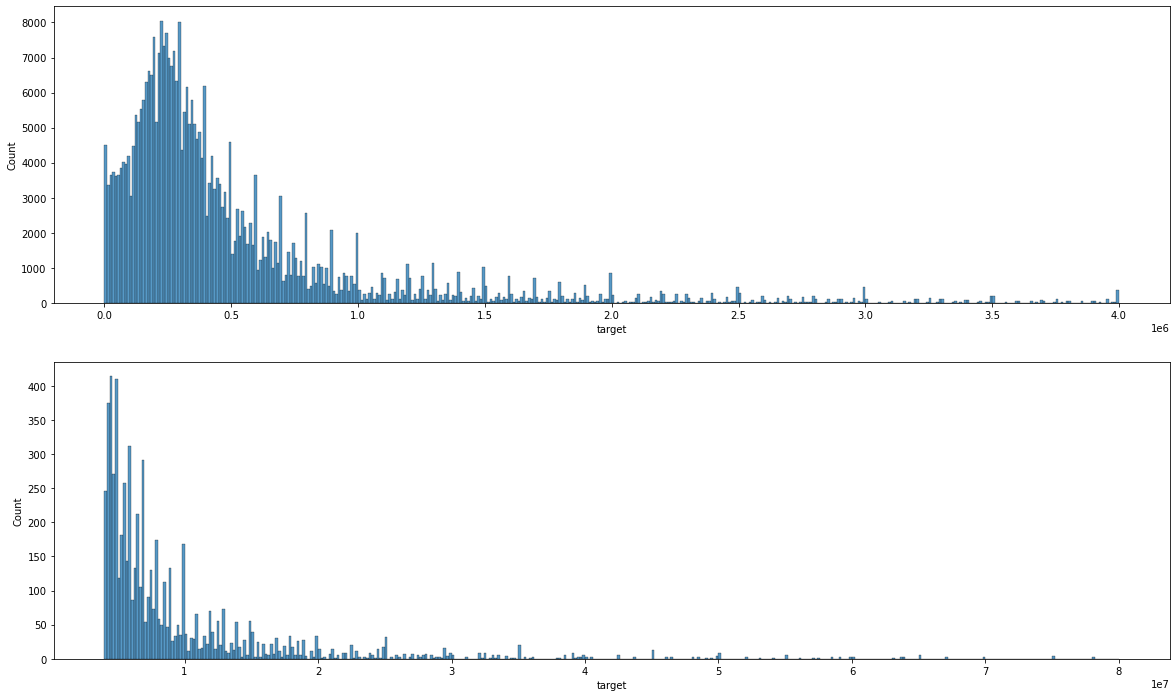

In [22]:
fig, ax = plt.subplots(figsize = (20, 12))
plt.subplot(211)
sns.histplot(data.target, binwidth=10000, binrange=(0,4000000))
plt.subplot(212)
sns.histplot(data.target, binwidth=200000, binrange=(4000000,80000000))

# Исследование целевой переменной

* Цена имеет очень широкий диапазон значений от 1 доллара до 195 млн.долларов. Несмотря на такой разброс - это не "качество", а его отсутствие. надо понимать, что цены на дома или недвижимость в целом в Америке (да и где бы то ни было) не могут иметь цену в 1, 10, 100, 1000 или даже 10 000 долларов. Есть подозрение, что цены менее 50 000 - подозрительны. Так что, предметом дальнейшего исследования целевой переменной будет оценка нижней границы отсеивания данных. В конечную модель эти данные подавать нельзя. Смысл таких цифр в графе "цена" - это просто заполнить его, как "обязательное" по условиям формы. А реальная цена собственником будет оперделятся при других обстоятельствах. Но эти обстоятельства нами не могут быть дифференцируемы.
* График демонстрирует условную "гладкость" распределения значений цены. Однако, надо учитывать специфику предмета "цена недвижимости". Несмотря на кажущийся огромным массив записей, несмотря на то, что некоторые значения формируются по строгой формуле *(цена)* * *(площадь)*, все равно, конечная цена будет сформирована субъективно. Мы и сейчас на графике наблюдаем пики прямо у "круглых" значений цены. Таким образом, учитывая, что это не массив данных о конечных сделках, а заявления продавцов о своих желаниях, вполне уместно было бы округлить цены до ближайших значений кратных десятичной степени в большую сторону. Вопрос стоит только в определении разряда округления. Скорее всего нужно рассмотреть схему окургления до "n-3 разряда".
* Учитывая широкий диапазон значений, понятно, что избежать логарифмирования целевой переменной в процессе применения ML или DL моделей не удастся.
* В базе данных менее 0.5% записей с объектами ценой более 10 млн.долларов. По всему видно, что это эксклюзивные предложения, которых вообще не так много. Соответственно и цены на них сформированы не сходя из стандартного списка параметров. Стоит рассмотреть механизм моделирования таких вариантов отдельно.
* В итоге работы следует определиться с практическим применением результатов работы модели. Вариантом такого применения может быть поиск предложений, цена на которые была бы ниже предсказанной. При этом у модели нужно предусмотреть настройку, чтобы ошибка "вверх", то есть, переоценка цены была бы минимальная, а чаще имело место недооценка.

In [23]:
def round_price(price):
    return np.around(price, -(len(str(price))-3))

n = [15670, 870998, 3298701, 22760983, 616143005]

for item in range(len(n)):
    print(n[item],' -> ', round_price(n[item]))

15670  ->  15700
870998  ->  871000
3298701  ->  3300000
22760983  ->  22800000
616143005  ->  616000000


In [24]:
# clean data from record of rental
data.status.fillna('nan', inplace=True)
data.status = data.status.apply(str.lower)

#filter records with realty for rent
rent = data[data.status.str.contains('rent')]
data = data[~data.status.str.contains('rent')]

## Vector 'private_pool'

In [25]:
pp = data.loc[:,['private_pool', 'PrivatePool']]
pp.fillna('na', inplace=True)
pp['compare'] = data.apply(lambda q: q.private_pool == q.PrivatePool, axis=1)

In [26]:
pp.groupby(['private_pool', 'PrivatePool'])['compare'].count()

private_pool  PrivatePool
Yes           na               4137
na            Yes             11353
              na             315169
              yes             28451
Name: compare, dtype: int64

In [27]:
pp_replace={'yes':1, 'na':0}

In [28]:
pp.private_pool = pp.private_pool.apply(str.lower).map(pp_replace)
pp.PrivatePool = pp.PrivatePool.apply(str.lower).map(pp_replace)
pp.groupby(['private_pool', 'PrivatePool'])['compare'].count()

private_pool  PrivatePool
0             0              315169
              1               39804
1             0                4137
Name: compare, dtype: int64

In [29]:
pp['pool'] = pp.private_pool + pp.PrivatePool
pp.groupby(['pool', 'private_pool', 'PrivatePool'])['compare'].count()

pool  private_pool  PrivatePool
0     0             0              315169
1     0             1               39804
      1             0                4137
Name: compare, dtype: int64

In [30]:
data.private_pool = pp.pool
data.drop('PrivatePool', inplace=True, axis=1)
del pp
gc.collect()

1113

In [33]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1185358	total: 29.8ms	remaining: 29.7s
1:	learn: 1.0498676	total: 54.9ms	remaining: 27.4s
2:	learn: 0.9903212	total: 79ms	remaining: 26.2s
3:	learn: 0.9382917	total: 102ms	remaining: 25.3s
4:	learn: 0.8920758	total: 123ms	remaining: 24.4s
5:	learn: 0.8513253	total: 147ms	remaining: 24.3s
6:	learn: 0.8165524	total: 170ms	remaining: 24.1s
7:	learn: 0.7852792	total: 201ms	remaining: 25s
8:	learn: 0.7569767	total: 225ms	remaining: 24.7s
9:	learn: 0.7328033	total: 252ms	remaining: 24.9s
10:	learn: 0.7110094	total: 290ms	remaining: 26.1s
11:	learn: 0.6918538	total: 324ms	remaining: 26.7s
12:	learn: 0.6747607	total: 356ms	remaining: 27s
13:	learn: 0.6600661	total: 382ms	remaining: 26.9s
14:	learn: 0.6463263	total: 409ms	remaining: 26.9s
15:	learn: 0.6340898	total: 438ms	remaining: 26.9s
16:	learn: 0.6239347	total: 488ms	remaining: 28.2s
17:	learn: 0.6147930	total: 533ms	remaining: 29.1s
18:	learn: 0.6069079	total: 554ms	remaining: 28.6s
19:	learn: 0.5

In [27]:
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# accuracy = 85.00, MAPE 383.13%, SMAPE 11.76%, MAE 17_798_542, PL 57366,  op 113937, up 261892  -  drop status
# accuracy = 86.72, MAPE 338.46%, SMAPE 11.61%, MAE 18_777_345, PL 58477,  op 114306, up 262806  -  drop rent
# accuracy = 86.81, MAPE 319.26%, SMAPE 11.55%, MAE 18_733_201, PL 58840,  op 114735, up 261892  -  status dummy
# ----
# accuracy = 86.92, MAPE 310.89%, SMAPE 11.53%, MAE 18_692_309, PL 58618,  op 114298, up 261501  -  pool clean

#### homeFacts
extract data from vector 'homeFacts' to new vectors

In [31]:
def home_facts(item):
    item = item['atAGlanceFacts']
    values = []
    for i in item:
        if i:
            values.append(i['factValue'])
        else:
            ''
    build, renovate, heating, cooling, parking, lotsize, price_sqft = values
    return build, renovate, heating, cooling, parking, lotsize, price_sqft

In [32]:
data['build'] = data.homeFacts.apply(lambda q: home_facts(q)[0])
data['renovate'] = data.homeFacts.apply(lambda q: home_facts(q)[1])
data['heating'] = data.homeFacts.apply(lambda q: home_facts(q)[2])
data['cooling'] = data.homeFacts.apply(lambda q: home_facts(q)[3])
data['parking'] = data.homeFacts.apply(lambda q: home_facts(q)[4])
data['lotsize'] = data.homeFacts.apply(lambda q: home_facts(q)[5])
data['price_sqft'] = data.homeFacts.apply(lambda q: home_facts(q)[6])

In [33]:
#data[['build', 'renovate', 'heating', 'cooling', 'parking', 'lotsize', 'price_sqft']] = data.homeFacts.apply(list(home_facts))

# Extracting numeric data
* lot size
* sqft price
* bathes
* beds

#### 'lotsize' and 'sqft'

In [34]:
data[['sqft', 'lotsize']]

,sqft,lotsize
0,2900,None
1,"1,947 sqft",5828 sqft
2,"3,000 sqft","8,626 sqft"
3,"6,457 sqft","8,220 sqft"
4,NaN,"10,019 sqft"
...,...,...
377180,"4,017","8,500 sqft"
377181,"2,000 sqft",
377182,"1,152 sqft","1,600 sqft"
377183,NaN,None


In [35]:
square = data[['sqft', 'lotsize']].copy()
square.fillna('nan', inplace=True)

In [36]:
def literal_text(item):
    """
    function take only literal part of 'item' value
    :param item: original value
    :return: text from value, if no literal - 'nan'
    """
    pattern = '[0-9,]+'
    result = re.sub(pattern, '', item)
    if result:
        return result
    else:
        return 'nan'

In [37]:
# make vectors with literal parts of vectors 'sqft' and 'lotsize'
square['sqft_text'] = square.sqft.apply(literal_text).apply(str.lower)
square['lot_text'] = square.lotsize.apply(literal_text).apply(str.lower)

In [38]:
def square_clearing(value, literal):
    """
    function is clearing data in vectors 'sqft' and 'lotsize', extract numeric value and transform acres to sqft
    :param value: original value in vector
    :param literal: literal part of original value
    :return: value of square feets in numeric format
    """
    arc, sqft = False, False
    try:
        if re.search('acr', literal):
            arc = True
    except: pass

    try:
        if re.search('sq', literal):
            sqft = True
    except: pass

    value = float(find_number(value))

    if arc:
        value = np.around(value * 43560)        # 1 acre = 43560 sq.feets

    return value

In [39]:
square['sqft_value']=square.apply(lambda q: square_clearing(q.sqft, q.sqft_text), axis=1)
square['lot_value']=square.apply(lambda q: square_clearing(q.lotsize, q.lot_text), axis=1)

In [40]:
data.loc[:,['sqft_value', 'lot_value']] = square.loc[:,['sqft_value', 'lot_value']]
del square
gc.collect()

75

In [41]:
# records with the same address, square and target - is the same, even if they have different baths number...,
# so - drop thees records
data.drop_duplicates(subset=['street', 'city', 'sqft_value', 'target'], inplace=True)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332386 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        332386 non-null  object 
 1   private_pool  332386 non-null  int64  
 2   propertyType  298472 non-null  object 
 3   street        332386 non-null  object 
 4   baths         237024 non-null  object 
 5   homeFacts     332386 non-null  object 
 6   fireplace     91384 non-null   object 
 7   city          332377 non-null  object 
 8   schools       332386 non-null  object 
 9   sqft          293288 non-null  object 
 10  zipcode       332386 non-null  object 
 11  beds          253444 non-null  object 
 12  state         332386 non-null  object 
 13  stories       199876 non-null  object 
 14  mls_id        22589 non-null   object 
 15  MlsId         273960 non-null  object 
 16  target        332386 non-null  int64  
 17  build         329126 non-null  object 
 18  reno

In [127]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1142957	total: 94.2ms	remaining: 1m 34s
1:	learn: 1.0438070	total: 120ms	remaining: 1m
2:	learn: 0.9770308	total: 150ms	remaining: 49.8s
3:	learn: 0.9210642	total: 178ms	remaining: 44.4s
4:	learn: 0.8702656	total: 214ms	remaining: 42.5s
5:	learn: 0.8231787	total: 240ms	remaining: 39.7s
6:	learn: 0.7814153	total: 274ms	remaining: 38.8s
7:	learn: 0.7457515	total: 321ms	remaining: 39.8s
8:	learn: 0.7147655	total: 362ms	remaining: 39.9s
9:	learn: 0.6853649	total: 390ms	remaining: 38.6s
10:	learn: 0.6590888	total: 421ms	remaining: 37.9s
11:	learn: 0.6352333	total: 453ms	remaining: 37.3s
12:	learn: 0.6145916	total: 486ms	remaining: 36.9s
13:	learn: 0.5961952	total: 514ms	remaining: 36.2s
14:	learn: 0.5791583	total: 557ms	remaining: 36.5s
15:	learn: 0.5638988	total: 600ms	remaining: 36.9s
16:	learn: 0.5497920	total: 631ms	remaining: 36.5s
17:	learn: 0.5374885	total: 666ms	remaining: 36.3s
18:	learn: 0.5253179	total: 699ms	remaining: 36.1s
19:	learn: 0

In [125]:
# Target, privet_pool, homeFacts extract, square clearing
# accuracy = 86.93, MAPE 299.39%, SMAPE 11.52%, MAE 18_675_602, PL 58150,  op 113228, up 262439  -  naive
# ----
# accuracy = 93.58, MAPE 288.24%, SMAPE 6.06%, MAE 12_240_875, PL 40686,  op 78925, up 167706

#### 'price_sqft' and 'sqft_value'

 + Вектор "price_sqft" загрязнен знаком доллара и текстом, раскрывающим суть данных - это стоимость одного квадратного фута дома (квартиры). Для модели выделим числовое значение из текста.
 + Так же есть записи, где отстутствует часть информации: или нет цены за фут, или нет площади. Через формулу можем восстановить эти данные

In [39]:
data.price_sqft

0              $144
1         $159/sqft
2         $965/sqft
3         $371/sqft
4              None
            ...    
377180         $311
377181    $337/sqft
377182    $458/sqft
377183         None
377184         $140
Name: price_sqft, Length: 374292, dtype: object

In [43]:
price_lot = data[['target', 'price_sqft', 'sqft_value']].copy()
price_lot.fillna('0', inplace=True)
price_lot['price_value'] = price_lot.price_sqft.apply(find_number).apply(int)

# recalculating data
for item in tqdm(price_lot.index):
    record = price_lot.loc[item]
    target, sqft, price = record.target, record.sqft_value, record.price_value
    if sqft and not price:
        price = target / sqft
        price_lot.loc[item, 'price_value']=price
    if not sqft and price:
        sqft = target / price
        price_lot.loc[item, 'sqft_value']=sqft

  0%|          | 0/332386 [00:00<?, ?it/s]

In [44]:
data[['sqft_value', 'price_value']] = price_lot[['sqft_value', 'price_value']]
del price_lot
gc.collect()

60

In [257]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                'price_sqft', 'sqft', 'lotsize'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1087085	total: 43.4ms	remaining: 43.4s
1:	learn: 1.0326079	total: 77.7ms	remaining: 38.8s
2:	learn: 0.9643574	total: 108ms	remaining: 35.8s
3:	learn: 0.9033943	total: 139ms	remaining: 34.6s
4:	learn: 0.8481215	total: 178ms	remaining: 35.4s
5:	learn: 0.8010290	total: 232ms	remaining: 38.4s
6:	learn: 0.7585407	total: 274ms	remaining: 38.9s
7:	learn: 0.7195936	total: 315ms	remaining: 39.1s
8:	learn: 0.6849854	total: 369ms	remaining: 40.6s
9:	learn: 0.6542502	total: 424ms	remaining: 42s
10:	learn: 0.6276857	total: 468ms	remaining: 42.1s
11:	learn: 0.6044281	total: 520ms	remaining: 42.8s
12:	learn: 0.5813441	total: 580ms	remaining: 44.1s
13:	learn: 0.5615958	total: 644ms	remaining: 45.3s
14:	learn: 0.5435504	total: 684ms	remaining: 44.9s
15:	learn: 0.5287899	total: 721ms	remaining: 44.4s
16:	learn: 0.5157569	total: 767ms	remaining: 44.3s
17:	learn: 0.5011277	total: 825ms	remaining: 45s
18:	learn: 0.4891543	total: 911ms	remaining: 47s
19:	learn: 0.47

In [ ]:
# accuracy = 94.58, MAPE 288.9%, SMAPE 4.18%, MAE 8_366_968, PL 25000,  op 48543, up 119930

#### baths

In [45]:
def vocabulary(vector, dataframe, keys=False, sep=','):
    """
    function to make vocabulary from vector
    :param vector: vector to analyse
    :param dataframe: dataframe to analyse
    :param keys: bool flag to make dictionary or dataframe. Default value = True => dictionary
    :param sep: text separator, Default value = ','
    :return: dictionary of key as literals and values as frequency in vector or dataframe from result dictionary
    """
    from collections import Counter
    vocab_set = []
    for record in dataframe[vector]:
        try:
            for item in str(record).split(sep):
                vocab_set.append(item)
        except:
            vocab_set.append(str(record))
    if keys:
        result = Counter(vocab_set)
    else:
        result = pd.DataFrame.from_dict(Counter(vocab_set),
                                        orient='index',
                                        columns=['count']).sort_values(by='count' , ascending=False)
    return result

In [46]:
# filling NaN with string value 'nan' and turn texts to lower case
data.baths.fillna('nan', inplace=True)
data.baths = data.baths.str.lower()

In [47]:
# extract values from vector 'bath'
baths = data[['sqft_value', 'lot_value', 'baths', 'beds']].copy()
baths['baths_value'] = baths.baths.apply(find_number).apply(float)
# some data seems to have mistaken format. For example 1,500 - it is 1.5. So normalise this.
baths['baths_value'] = baths.baths_value.apply(lambda q: q if q<250 else q/1000)
# as for normal understanding 2.5 baths means 2 full baths and 1 - half bath or
# 2.2 - 2 full baths and 2 half baths.
# So - recalculate it to just quantity (actually - round to the ceil)
baths['baths_value'] = baths.baths_value.apply(math.ceil)

In [49]:
# some records don't have values of baths. But we can recalculate it
# from square of house (vector 'sqft_values').
# If 'sqft_value' is empty, we try to use vector 'lot_value'.
# And make ceil of number of baths as 50.
for item in tqdm(baths.index):
    record = baths.loc[item,:]
    sqft, lot, value = record.sqft_value, record.lot_value, record.baths_value
    if not value:
        if sqft:
            value = min(50, math.ceil(sqft/1000))
        else:
            value = min(50, math.ceil(lot/1000))

        baths.loc[item, 'baths_value'] = value

  0%|          | 0/332386 [00:00<?, ?it/s]

In [50]:
baths.groupby('baths_value')['sqft_value'].agg(['min', 'mean', 'median', 'max', 'count'])

,min,mean,median,max,count
baths_value,,,,,
0,0.0,0.000000,0.0,0.0,11565
1,0.0,1069.078643,840.0,651914.0,33193
2,0.0,8154.944844,1457.0,795979430.0,125963
3,0.0,2427.120490,2237.0,2807917.0,84685
4,0.0,3180.729925,3105.0,678055.0,32897
5,0.0,3935.868043,4082.0,220000.0,11823
6,0.0,4591.658371,5000.0,550905.0,5679
7,0.0,4442.410912,5564.0,120073.0,3347
8,0.0,3859.373404,3818.5,26638.0,2364


In [51]:
data['baths_value'] = baths.baths_value

In [377]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                #'baths'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.107692
0:	learn: 1.1091124	total: 43.7ms	remaining: 43.6s
1:	learn: 1.0316594	total: 73.2ms	remaining: 36.5s
2:	learn: 0.9651101	total: 101ms	remaining: 33.6s
3:	learn: 0.9051308	total: 128ms	remaining: 31.8s
4:	learn: 0.8494851	total: 161ms	remaining: 31.9s
5:	learn: 0.7998799	total: 197ms	remaining: 32.6s
6:	learn: 0.7576812	total: 230ms	remaining: 32.6s
7:	learn: 0.7192739	total: 257ms	remaining: 31.8s
8:	learn: 0.6835760	total: 300ms	remaining: 33.1s
9:	learn: 0.6509516	total: 364ms	remaining: 36.1s
10:	learn: 0.6235817	total: 434ms	remaining: 39.1s
11:	learn: 0.5994132	total: 468ms	remaining: 38.5s
12:	learn: 0.5764174	total: 504ms	remaining: 38.3s
13:	learn: 0.5565762	total: 540ms	remaining: 38s
14:	learn: 0.5388306	total: 602ms	remaining: 39.5s
15:	learn: 0.5229308	total: 638ms	remaining: 39.2s
16:	learn: 0.5094468	total: 669ms	remaining: 38.7s
17:	learn: 0.4955197	total: 714ms	remaining: 38.9s
18:	learn: 0.4829062	total: 791ms	remaining: 40.9s
19:	learn: 

In [52]:
# accuracy = 94.79, MAPE 299.47%, SMAPE 4.17%, MAE 8_325_958, PL 25172,  op 49509, up 117235

In [53]:
data[(data.sqft_value!=0)|(data.lot_value!=0)]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,renovate,heating,cooling,parking,lotsize,price_sqft,sqft_value,lot_value,price_value,baths_value
0,active,0,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,,"Central A/C, Heat Pump",,,None,$144,2900.0,0.0,144.0,4
1,for sale,0,single-family home,12911 E Heroy Ave,3 baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",...,,,,,5828 sqft,$159/sqft,1947.0,5828.0,159.0,3
2,for sale,1,single-family home,2005 Westridge Rd,2 baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",...,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,3000.0,8626.0,965.0,2
3,for sale,0,single-family home,4311 Livingston Ave,8 baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",...,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,6457.0,8220.0,371.0,8
4,for sale,0,lot/land,1524 Kiscoe St,nan,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,...,,,,,"10,019 sqft",None,0.0,10019.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377179,for sale,0,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",...,None,Forced air,Central,1 space,None,$564,1417.0,0.0,564.0,3
377180,nan,1,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",...,1990,Other,Central,2 spaces,"8,500 sqft",$311,4017.0,8500.0,311.0,6
377181,for sale,0,condo,3530 N Lake Shore Dr #4B,3 baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",...,,Radiant,,None,,$337/sqft,2000.0,0.0,337.0,3
377182,for sale,0,single-family home,15509 Linden Blvd,3 baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",...,1950,Other,,2,"1,600 sqft",$458/sqft,1152.0,1600.0,458.0,3


In [54]:
# try to drop records with empty 'sqft_value' and 'lot_value' - where we do not have data about sqare of house
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
drop_records = (data.sqft_value!=0)|(data.lot_value!=0)
feature_imp(data[drop_records].drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.106932
0:	learn: 1.0854598	total: 104ms	remaining: 1m 43s
1:	learn: 1.0074904	total: 143ms	remaining: 1m 11s
2:	learn: 0.9371039	total: 180ms	remaining: 59.8s
3:	learn: 0.8722540	total: 217ms	remaining: 54s
4:	learn: 0.8172940	total: 246ms	remaining: 48.9s
5:	learn: 0.7665549	total: 282ms	remaining: 46.7s
6:	learn: 0.7208618	total: 323ms	remaining: 45.8s
7:	learn: 0.6819634	total: 380ms	remaining: 47.1s
8:	learn: 0.6482923	total: 417ms	remaining: 46s
9:	learn: 0.6150964	total: 459ms	remaining: 45.4s
10:	learn: 0.5876643	total: 491ms	remaining: 44.1s
11:	learn: 0.5611453	total: 532ms	remaining: 43.8s
12:	learn: 0.5391861	total: 584ms	remaining: 44.3s
13:	learn: 0.5188903	total: 615ms	remaining: 43.3s
14:	learn: 0.5003370	total: 644ms	remaining: 42.3s
15:	learn: 0.4846432	total: 679ms	remaining: 41.8s
16:	learn: 0.4709713	total: 715ms	remaining: 41.4s
17:	learn: 0.4563496	total: 750ms	remaining: 40.9s
18:	learn: 0.4444363	total: 782ms	remaining: 40.4s
19:	learn: 0.

In [386]:
# accuracy = 95.69, MAPE 635.86%, SMAPE 3.46%, MAE 5_086_434, PL 18_835,  op 37328, up 64454

In [52]:
# Decide to drop records, which don't have any square data (about 14K records)
drop_records = (data.sqft_value!=0)|(data.lot_value!=0)
data = data[drop_records]

In [53]:
del baths
gc.collect()

213

#### 'beds'

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359698 entries, 0 to 377184
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        359698 non-null  object 
 1   private_pool  359698 non-null  int64  
 2   propertyType  335764 non-null  object 
 3   street        359696 non-null  object 
 4   baths         359698 non-null  object 
 5   homeFacts     359698 non-null  object 
 6   fireplace     102120 non-null  object 
 7   city          359670 non-null  object 
 8   schools       359698 non-null  object 
 9   sqft          333254 non-null  object 
 10  zipcode       359698 non-null  object 
 11  beds          277173 non-null  object 
 12  state         359698 non-null  object 
 13  stories       223882 non-null  object 
 14  mls_id        24766 non-null   object 
 15  MlsId         296180 non-null  object 
 16  target        359698 non-null  int64  
 17  build         359086 non-null  object 
 18  reno

In [54]:
beds = data[['sqft_value', 'lot_value', 'baths_value', 'beds']].copy()
beds.beds.fillna('nn', inplace=True)
beds.beds = beds.beds.apply(str.lower)
beds['beds_text'] = beds.beds.apply(literal_text)

In [55]:
qq = vocabulary('beds_text',beds)
qq

,count
beds,118511
nn,70829
nan,69524
bd,27786
.,15962
baths,14387
-- bd,739
bath,383
,306
sqft,19


In [56]:
# only texts " beds", " bd", ".", "nan" are mean that numeric value is number of beds
key_text = ' beds bd.nan'
for item in tqdm(beds.index):

    record = beds.loc[item,:]
    value, value_text = record.beds, record.beds_text

    if re.search(value_text, key_text): # look for key text and get numeric value from record
        value = find_number(value)
    else:
        value = 0

    beds.loc[item, 'beds_value'] = value

  0%|          | 0/318466 [00:00<?, ?it/s]

In [57]:
beds.beds_value = beds.beds_value.apply(float).apply(int)

In [ ]:
beds[beds.beds_text=='baths']

In [58]:
beds[beds.beds_value>0].groupby('beds_value')['sqft_value'].agg(['min', 'mean', 'median', 'max', 'count'])

,min,mean,median,max,count
beds_value,,,,,
1,0.0,1237.428974,762.0,651914.0,5771
2,0.0,19888.945121,1190.0,795979430.0,46038
3,0.0,2019.663358,1692.0,1611720.0,92207
4,0.0,2683.826761,2454.0,539027.0,59073
5,0.0,3793.896739,3390.0,600613.0,18303
6,0.0,4364.327595,3593.0,120073.0,5490
7,0.0,5343.047608,4012.0,218907.0,1541
8,0.0,4699.318037,3604.0,36000.0,1033
9,0.0,4964.307076,3826.0,34039.0,432


In [103]:
beds.beds_value.value_counts(())

3      104346
0       99889
4       68234
2       48924
5       21483
6        6448
1        5929
7        1791
8        1189
9         472
10        264
12        179
11        129
16         66
13         48
64         44
14         43
15         33
18         29
24         29
20         19
17         12
28          9
22          8
32          8
26          8
19          6
27          5
21          5
30          4
23          4
34          4
40          4
25          3
44          3
36          3
48          2
47          2
29          2
78          2
42          2
33          2
88          1
99          1
76          1
75          1
46          1
53          1
52          1
51          1
39          1
35          1
31          1
144         1
Name: beds_value, dtype: int64

In [59]:
for item in tqdm(beds.index):
    record = beds.loc[item,:]
    sqft, lot, value = record.sqft_value, record.lot_value, record.beds_value
    if not value:
        if sqft:
            value = min(25, math.ceil(sqft/650))
        else:
            value = min(25, math.ceil(lot/650))

        beds.loc[item, 'beds_value'] = value

  0%|          | 0/318466 [00:00<?, ?it/s]

In [110]:
beds.beds_value.value_counts()

3      120384
4       79615
2       67829
5       28217
25      18142
1       10524
6       10087
7        4068
16       3565
8        3114
9        1714
17       1623
12       1418
10       1399
11       1250
15       1054
13        944
19        818
14        774
18        685
21        632
23        571
20        535
22        331
24        289
64         44
28          9
32          8
26          8
27          5
34          4
40          4
30          4
36          3
44          3
47          2
29          2
33          2
42          2
78          2
48          2
99          1
88          1
76          1
75          1
31          1
53          1
52          1
51          1
46          1
39          1
35          1
144         1
Name: beds_value, dtype: int64

In [60]:
data['beds_value'] = beds.beds_value

In [116]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                #'beds',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.106932
0:	learn: 1.0869443	total: 38.5ms	remaining: 38.5s
1:	learn: 1.0072529	total: 63.9ms	remaining: 31.9s
2:	learn: 0.9362903	total: 91.6ms	remaining: 30.4s
3:	learn: 0.8720249	total: 115ms	remaining: 28.7s
4:	learn: 0.8169506	total: 143ms	remaining: 28.5s
5:	learn: 0.7660800	total: 174ms	remaining: 28.8s
6:	learn: 0.7216895	total: 207ms	remaining: 29.4s
7:	learn: 0.6831894	total: 237ms	remaining: 29.4s
8:	learn: 0.6473366	total: 274ms	remaining: 30.2s
9:	learn: 0.6143688	total: 323ms	remaining: 32s
10:	learn: 0.5863521	total: 386ms	remaining: 34.7s
11:	learn: 0.5619213	total: 419ms	remaining: 34.5s
12:	learn: 0.5383826	total: 450ms	remaining: 34.1s
13:	learn: 0.5165870	total: 483ms	remaining: 34s
14:	learn: 0.4988246	total: 515ms	remaining: 33.8s
15:	learn: 0.4830711	total: 573ms	remaining: 35.2s
16:	learn: 0.4680387	total: 606ms	remaining: 35.1s
17:	learn: 0.4550227	total: 635ms	remaining: 34.7s
18:	learn: 0.4442474	total: 672ms	remaining: 34.7s
19:	learn: 0

In [ ]:
# accuracy = 95.72, MAPE 701.76%, SMAPE 3.47%, MAE 5_062_673, PL 18_800,  op 37017, up 64472

#### parking

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359698 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        359698 non-null  object 
 1   private_pool  359698 non-null  int64  
 2   propertyType  335764 non-null  object 
 3   street        359696 non-null  object 
 4   baths         359698 non-null  object 
 5   homeFacts     359698 non-null  object 
 6   fireplace     102120 non-null  object 
 7   city          359670 non-null  object 
 8   schools       359698 non-null  object 
 9   sqft          333254 non-null  object 
 10  zipcode       359698 non-null  object 
 11  beds          277173 non-null  object 
 12  state         359698 non-null  object 
 13  stories       223882 non-null  object 
 14  mls_id        24766 non-null   object 
 15  MlsId         296180 non-null  object 
 16  target        359698 non-null  int64  
 17  build         359086 non-null  object 
 18  reno

In [61]:
parking = data[['parking', 'sqft_value', 'lot_value']].copy()
parking.parking.fillna('no data', inplace=True)

parking.parking=parking.parking.apply(lambda q: q.lower())
parking.parking.value_counts()

                                                                 143429
attached garage                                                   62063
2 spaces                                                          22215
1 space                                                           12571
no data                                                           11975
                                                                  ...  
on street, off street, attached garage, carport                       1
assigned, assigned, paved                                             1
attached - side, aggre, cirdw, drvwy                                  1
garage-double attached                                                1
assigned parking space - 1, parking garage, parking space - 1         1
Name: parking, Length: 3101, dtype: int64

In [62]:
# '' => 'no data'
# 0, => none
# '888' => '2 spaces'

parking.loc[parking.parking=='', 'parking'] = 'no data'
parking.loc[parking.parking==0, 'parking'] = 'none'
parking.loc[parking.parking=='888', 'parking'] = '2 spaces'
parking.parking.value_counts()

no data                                                          155404
attached garage                                                   62063
2 spaces                                                          22418
1 space                                                           12571
detached garage                                                   11727
                                                                  ...  
on street, off street, attached garage, carport                       1
assigned, assigned, paved                                             1
attached - side, aggre, cirdw, drvwy                                  1
garage-double attached                                                1
assigned parking space - 1, parking garage, parking space - 1         1
Name: parking, Length: 3099, dtype: int64

In [155]:
data[data.parking.str.contains('data')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,heating,cooling,parking,lotsize,price_sqft,sqft_value,lot_value,price_value,baths_value,beds_value
33,nan,0,Condo,3750 NE 170th St APT 407,2.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,North Miami Beach,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...","1,085",...,Forced air,Central,no data,None,$165,1085.0,0.0,165.0,2,2
37,for sale,0,Single Family,3360 SW 29th St,2,"{'atAGlanceFacts': [{'factValue': '1954', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,396",...,Forced air,Central,no data,"5,998 sqft",$355,1396.0,5998.0,355.0,2,3
52,nan,0,Condo,3131 NE 7th Ave UNIT 4801,4.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","1,873",...,Forced air,Central,no data,None,$950,1873.0,0.0,950.0,4,3
80,new construction,0,Single Family,5315 Fayetteville Rd,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,Durham,"[{'rating': ['5/10', '3/10', '4/10'], 'data': ...","2,375",...,Forced air,Central,no data,0.36 acres,$168,2375.0,15682.0,168.0,3,4
107,nan,0,Condo,2831 S Bayshore Dr UNIT 1906,2.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,369",...,Forced air,Central,no data,None,"$1,132",1369.0,0.0,1132.0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377096,nan,0,Townhouse,8821 Kolbe Bend Ln,4,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","2,619",...,No Data,No Data,no data,"2,548 sqft",$200,2619.0,2548.0,200.0,4,3
377102,for sale,1,Condo,3333 NE 34th St APT 1614,1,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...",850,...,Forced air,Central,no data,None,$176,850.0,0.0,176.0,1,1
377131,nan,0,Condo,9760 SW 184th St APT 12D,1.0,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Cutler Bay,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",765,...,Forced air,Central,no data,None,$131,765.0,0.0,131.0,1,2
377166,nan,1,Single Family,3540 Palmetto Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,740",...,Forced air,Central,no data,0.32 acres,$833,1740.0,13939.0,833.0,3,3


In [63]:
parking[['parking_places', 'attached', 'detached', 'carport']]=0
for item in tqdm(parking.index):
    record = parking.loc[item,:]
    raw = record.parking
    value, text_value = int(float(find_number(raw))), str(raw)

    if not value: value = 2

    if raw=='none': value = 0

    parking.loc[item, 'parking_places']=value

    vectors = ['attached', 'detached', 'carport']
    for vector in vectors:
        if re.search(vector, text_value):
            parking.loc[item, vector]=1


  0%|          | 0/318466 [00:00<?, ?it/s]

In [64]:
parking.fillna(0, inplace=True)
parking

,parking,sqft_value,lot_value,parking_places,attached,detached,carport
0,no data,2900.0,0.0,2,0,0,0
1,no data,1947.0,5828.0,2,0,0,0
2,attached garage,3000.0,8626.0,2,1,0,0
3,detached garage,6457.0,8220.0,2,0,1,0
4,no data,0.0,10019.0,2,0,0,0
...,...,...,...,...,...,...,...
377177,no data,1895.0,7500.0,2,0,0,0
377179,1 space,1417.0,0.0,1,0,0,0
377181,none,2000.0,0.0,0,0,0,0
377182,2,1152.0,1600.0,2,0,0,0


In [65]:
data[['parking_places', 'attached', 'detached', 'carport']] = parking[['parking_places', 'attached', 'detached', 'carport']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318466 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          318466 non-null  object 
 1   private_pool    318466 non-null  int64  
 2   propertyType    294821 non-null  object 
 3   street          318466 non-null  object 
 4   baths           318466 non-null  object 
 5   homeFacts       318466 non-null  object 
 6   fireplace       91084 non-null   object 
 7   city            318462 non-null  object 
 8   schools         318466 non-null  object 
 9   sqft            292567 non-null  object 
 10  zipcode         318466 non-null  object 
 11  beds            247637 non-null  object 
 12  state           318466 non-null  object 
 13  stories         198873 non-null  object 
 14  mls_id          22438 non-null   object 
 15  MlsId           260824 non-null  object 
 16  target          318466 non-null  int64  
 17  build     

In [165]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',

                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.106932
0:	learn: 1.0857034	total: 41.8ms	remaining: 41.7s
1:	learn: 1.0051732	total: 75.7ms	remaining: 37.8s
2:	learn: 0.9355523	total: 107ms	remaining: 35.6s
3:	learn: 0.8718400	total: 140ms	remaining: 34.8s
4:	learn: 0.8173080	total: 179ms	remaining: 35.6s
5:	learn: 0.7655635	total: 227ms	remaining: 37.7s
6:	learn: 0.7205187	total: 269ms	remaining: 38.2s
7:	learn: 0.6804639	total: 310ms	remaining: 38.5s
8:	learn: 0.6458529	total: 432ms	remaining: 47.6s
9:	learn: 0.6139354	total: 482ms	remaining: 47.8s
10:	learn: 0.5867452	total: 542ms	remaining: 48.7s
11:	learn: 0.5630275	total: 595ms	remaining: 49s
12:	learn: 0.5387262	total: 638ms	remaining: 48.4s
13:	learn: 0.5184049	total: 692ms	remaining: 48.7s
14:	learn: 0.4997549	total: 736ms	remaining: 48.4s
15:	learn: 0.4837654	total: 783ms	remaining: 48.1s
16:	learn: 0.4687797	total: 831ms	remaining: 48s
17:	learn: 0.4542293	total: 893ms	remaining: 48.7s
18:	learn: 0.4421457	total: 963ms	remaining: 49.7s
19:	learn: 0.

In [ ]:
# accuracy = 95.69, MAPE 642.85%, SMAPE 3.48%, MAE 4_968_233, PL 17_665,  op 34846, up 64685

In [66]:
del parking, beds
gc.collect()

60

#### 'fireplace'

Работа не дала результатов. Точнее, результаты ухудшились.

In [238]:
fire = data[['fireplace', 'sqft_value', 'lot_value']].copy()

In [239]:
fire.fireplace.fillna('no data', inplace=True)
fire.fireplace = fire.fireplace.apply(str.lower)
fire.fireplace.value_counts()

no data                                                                                                       257578
yes                                                                                                            70302
1                                                                                                              14502
2                                                                                                               2429
not applicable                                                                                                  1988
                                                                                                               ...  
gas logs, gas starter, heatilator type system                                                                      1
1000+ sq. ft., deck/porch/patio, range/oven, fireplace, dishwasher, 3/more bedrooms, 2/more baths, 2 story         1
master bedroom, wood burning                                    

In [228]:
qq = vocabulary('fireplace', fire)
qq

,count
no data,257578
yes,70302
1,14504
2,2429
not applicable,1988
...,...
wood stove insert,1
heatilater,1
see agent,1
auto sprinkler,1


In [240]:
for item in tqdm(fire.index):
    record = fire.loc[item,:]
    raw = record.fireplace
    value, text_value = int(float(find_number(raw))), str(raw)

    vectors = ['gas', 'wood', 'electric']
    add_key = ['yes', 'room', 'rm', 'stove', 'decorative', 'fire', 'free',
               'zone', 'two', 'one', 'three', 'propane', 'kitchen']

    for vector in vectors:
        if re.search(vector, text_value):
            fire.loc[item, vector]=1
            if not value:
                value = 1

    if not value:
        for i in add_key:
            if re.search(i, text_value):
                value = 1
                break

    fire.loc[item, 'fireplace_number']=value

  0%|          | 0/359698 [00:00<?, ?it/s]

In [241]:
fire.fillna(0, inplace=True)
fire

,fireplace,sqft_value,lot_value,gas,fireplace_number,wood,electric
0,gas logs,2900.0,0.0,1.0,1.0,0.0,0.0
1,no data,1947.0,5828.0,0.0,0.0,0.0,0.0
2,yes,3000.0,8626.0,0.0,1.0,0.0,0.0
3,yes,6457.0,8220.0,0.0,1.0,0.0,0.0
4,no data,0.0,10019.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
377179,no data,1417.0,0.0,0.0,0.0,0.0,0.0
377180,no data,4017.0,8500.0,0.0,0.0,0.0,0.0
377181,no data,2000.0,0.0,0.0,0.0,0.0,0.0
377182,no data,1152.0,1600.0,0.0,0.0,0.0,0.0


In [242]:
data[['fireplace_number', 'gas', 'wood', 'electric']] = fire[['fireplace_number', 'gas', 'wood', 'electric']]
del fire
gc.collect()

211

In [250]:
data.fireplace.fillna('no data', inplace=True)
data.fireplace = data.fireplace.apply(str.lower)

In [251]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                #'fireplace_number', 'gas', 'wood', 'electric'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.106932
0:	learn: 1.0857034	total: 34.3ms	remaining: 34.2s
1:	learn: 1.0051732	total: 61.7ms	remaining: 30.8s
2:	learn: 0.9355523	total: 89.2ms	remaining: 29.6s
3:	learn: 0.8718400	total: 113ms	remaining: 28.1s
4:	learn: 0.8173080	total: 138ms	remaining: 27.6s
5:	learn: 0.7655635	total: 165ms	remaining: 27.4s
6:	learn: 0.7205187	total: 199ms	remaining: 28.2s
7:	learn: 0.6804639	total: 231ms	remaining: 28.6s
8:	learn: 0.6458529	total: 266ms	remaining: 29.3s
9:	learn: 0.6139354	total: 295ms	remaining: 29.2s
10:	learn: 0.5867452	total: 321ms	remaining: 28.9s
11:	learn: 0.5630275	total: 353ms	remaining: 29.1s
12:	learn: 0.5387262	total: 381ms	remaining: 28.9s
13:	learn: 0.5184049	total: 427ms	remaining: 30.1s
14:	learn: 0.4997549	total: 484ms	remaining: 31.8s
15:	learn: 0.4837654	total: 511ms	remaining: 31.4s
16:	learn: 0.4687797	total: 543ms	remaining: 31.4s
17:	learn: 0.4542293	total: 582ms	remaining: 31.7s
18:	learn: 0.4421457	total: 610ms	remaining: 31.5s
19:	lear

In [ ]:
# accuracy = 95.69, MAPE 642.85%, SMAPE 3.48%, MAE 4_968_233, PL 17_665,  op 34846, up 64685
# accuracy = 95.72, MAPE 709,56%, SMAPE 3.46%, MAE 5_054_233, PL 17_935,  op 37383, up 63931

In [253]:
data.drop(['fireplace_number', 'gas', 'wood', 'electric'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359698 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          359698 non-null  object 
 1   private_pool    359698 non-null  int64  
 2   propertyType    335764 non-null  object 
 3   street          359696 non-null  object 
 4   baths           359698 non-null  object 
 5   homeFacts       359698 non-null  object 
 6   fireplace       359698 non-null  object 
 7   city            359670 non-null  object 
 8   schools         359698 non-null  object 
 9   sqft            333254 non-null  object 
 10  zipcode         359698 non-null  object 
 11  beds            277173 non-null  object 
 12  state           359698 non-null  object 
 13  stories         223882 non-null  object 
 14  mls_id          24766 non-null   object 
 15  MlsId           296180 non-null  object 
 16  target          359698 non-null  int64  
 17  build     

#### vector 'build'

In [67]:
build = data[['build', 'target']].copy()
build.build.fillna('0', inplace=True)
build.build = build.build.apply(find_number).apply(int)
build

,build,target
0,2019,418000
1,2019,310000
2,1961,2895000
3,2006,2395000
4,0,5000
...,...,...
377177,1921,199900
377179,2010,799000
377181,1924,674999
377182,1950,528000


In [68]:
mask = (build.build>0)&(build.build!=559990649990)&(build.build!=1)
build[mask]['build'].median()

1985.0

In [69]:
avg = build[mask]['build'].median()
build.loc[~mask,'build']= avg

In [70]:
build.build.value_counts()

1985.0    43059
2019.0    26547
2006.0     7256
2005.0     6782
2007.0     6511
          ...  
1808.0        1
1735.0        1
1845.0        1
1740.0        1
1060.0        1
Name: build, Length: 224, dtype: int64

In [71]:
data['build_value'] = build.build

In [80]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.10464
0:	learn: 1.0430762	total: 28.2ms	remaining: 28.2s
1:	learn: 0.9695931	total: 55.2ms	remaining: 27.5s
2:	learn: 0.9047652	total: 77.6ms	remaining: 25.8s
3:	learn: 0.8423767	total: 103ms	remaining: 25.8s
4:	learn: 0.7877358	total: 126ms	remaining: 25.1s
5:	learn: 0.7392074	total: 155ms	remaining: 25.6s
6:	learn: 0.6962906	total: 184ms	remaining: 26.2s
7:	learn: 0.6555516	total: 217ms	remaining: 26.9s
8:	learn: 0.6215783	total: 241ms	remaining: 26.6s
9:	learn: 0.5885522	total: 274ms	remaining: 27.2s
10:	learn: 0.5606088	total: 306ms	remaining: 27.5s
11:	learn: 0.5367751	total: 343ms	remaining: 28.2s
12:	learn: 0.5127533	total: 390ms	remaining: 29.6s
13:	learn: 0.4925417	total: 419ms	remaining: 29.5s
14:	learn: 0.4747434	total: 445ms	remaining: 29.2s
15:	learn: 0.4590600	total: 476ms	remaining: 29.3s
16:	learn: 0.4454944	total: 508ms	remaining: 29.4s
17:	learn: 0.4318973	total: 533ms	remaining: 29.1s
18:	learn: 0.4201246	total: 579ms	remaining: 29.9s
19:	learn

In [ ]:
# (previous) accuracy = 95.69, MAPE 594.3%, SMAPE 3.47%, MAE 4_963_053, PL 17_939,  op 35349, up 64115
# (actual) accuracy = 96.12, MAPE 8,36%, SMAPE 3.07%, MAE 5_076_452, PL 20_441,  op 40507, up 61112

#### vector

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318466 entries, 0 to 377184
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          318466 non-null  object 
 1   private_pool    318466 non-null  int64  
 2   propertyType    294821 non-null  object 
 3   street          318466 non-null  object 
 4   baths           318466 non-null  object 
 5   homeFacts       318466 non-null  object 
 6   fireplace       91084 non-null   object 
 7   city            318462 non-null  object 
 8   schools         318466 non-null  object 
 9   sqft            292567 non-null  object 
 10  zipcode         318466 non-null  object 
 11  beds            247637 non-null  object 
 12  state           318466 non-null  object 
 13  stories         198873 non-null  object 
 14  mls_id          22438 non-null   object 
 15  MlsId           260824 non-null  object 
 16  target          318466 non-null  int64  
 17  build     

In [361]:
all_streets = data.street.value_counts().to_dict()
double_streets = {key: all_streets[key] for key in all_streets if all_streets[key] > 1}
double_streets

{'2103 E State Hwy 21': 55,
 '11305 Gulf Fwy': 51,
 '17030 Youngblood Rd.': 38,
 '9470 Lancaster Rd. SW': 32,
 '1 Palmer Dr': 26,
 '9845 Basil Western Rd NW': 25,
 '8426 Terrace Valley Circle': 25,
 '6320 SW 89th Court Road': 24,
 '8447 SW 99th Street Rd': 22,
 'Whitetail Trail': 19,
 '5221 S. Zapata Hwy': 18,
 'Stone Bluff Drive': 18,
 '2005 West Happy Valley Road': 17,
 '3435 Heather Garden Trail': 17,
 '1365 Neihart Way': 17,
 'Boncher Blvd': 17,
 '1727 Opal Field Lane': 17,
 '24423 Ferdossa Drive': 17,
 '3423 Heather Garden Trail': 17,
 '606 Vineyard Hollow Court': 16,
 '1024 Dali Blvd.': 16,
 '11 Pheasant Drive': 16,
 '13410 Canterbury Castle Drive': 15,
 '50 Leanni Way': 15,
 '9915 Camellia Gardens Drive': 15,
 '1009 Rio De Janeiro Ave': 15,
 '2914 Karlissa Trail': 14,
 '9522 Summer River Dr': 14,
 '3 Hemingway Avenue': 14,
 '4707 Staffordshire Lane': 14,
 '9200 Harrisburg Road': 14,
 '18122 Shimmer Lane': 14,
 '24807 Twilight Hollow Lane': 14,
 '14914 Bagley Lane': 13,
 '25 Orla

In [82]:
data[data.street == '5221 S. Zapata Hwy']

In [363]:
data

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,sqft_value,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value
67114,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,178",...,1178.0,0.0,47.0,2,3,2.0,0.0,0.0,0.0,1985.0
67704,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,980",...,1980.0,0.0,52.0,2,4,2.0,0.0,0.0,0.0,1985.0
94960,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,116",...,1116.0,0.0,38.0,2,3,2.0,0.0,0.0,0.0,1985.0
104815,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...",765,...,765.0,0.0,42.0,2,3,2.0,0.0,0.0,0.0,1985.0
137365,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,216",...,1216.0,0.0,46.0,2,3,2.0,0.0,0.0,0.0,1985.0
155920,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","2,078",...,2078.0,0.0,56.0,2,3,2.0,0.0,0.0,0.0,1985.0
159777,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,896",...,1896.0,0.0,34.0,2,3,2.0,0.0,0.0,0.0,1985.0
195531,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,170",...,1170.0,0.0,51.0,2,3,2.0,0.0,0.0,0.0,1985.0
202674,active,0,Single Family Home,5221 S. Zapata Hwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","1,475",...,1475.0,0.0,38.0,2,3,2.0,0.0,0.0,0.0,1985.0
208307,active,0,Single Family Home,5221 S. Zapata Hwy,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Laredo,"[{'rating': ['5', '5', '2', '6', 'NR', '1', 'N...","2,001",...,2001.0,0.0,38.0,3,5,2.0,0.0,0.0,0.0,1985.0


In [344]:
data_copy= data.copy()
data_copy.street.fillna('no data', inplace=True)
#data_copy['address']= data_copy.street + ' ' + data_copy.city
data_copy.drop_duplicates(subset=['street', 'city', 'sqft_value', 'target'], inplace=True)

In [345]:
data_copy.shape, data.shape

((328365, 35), (355569, 34))

In [330]:
data[~pd.isna(data.street)]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,sqft_value,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value
0,active,0,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",gas logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,2900.0,0.0,144.0,4,4,2.0,0.0,0.0,0.0,2019.0
1,for sale,0,single-family home,12911 E Heroy Ave,3 baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",no data,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",...,1947.0,5828.0,159.0,3,3,2.0,0.0,0.0,0.0,2019.0
2,for sale,1,single-family home,2005 Westridge Rd,2 baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",...,3000.0,8626.0,965.0,2,3,2.0,1.0,0.0,0.0,1961.0
3,for sale,0,single-family home,4311 Livingston Ave,8 baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",...,6457.0,8220.0,371.0,8,5,2.0,0.0,1.0,0.0,2006.0
4,for sale,0,lot/land,1524 Kiscoe St,nan,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",no data,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,...,0.0,10019.0,0.0,11,16,2.0,0.0,0.0,0.0,1985.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377179,for sale,0,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",no data,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",...,1417.0,0.0,564.0,3,2,1.0,0.0,0.0,0.0,2010.0
377180,nan,1,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",no data,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",...,4017.0,8500.0,311.0,6,5,2.0,0.0,0.0,0.0,1990.0
377181,for sale,0,condo,3530 N Lake Shore Dr #4B,3 baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",no data,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",...,2000.0,0.0,337.0,3,3,0.0,0.0,0.0,0.0,1924.0
377182,for sale,0,single-family home,15509 Linden Blvd,3 baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",no data,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",...,1152.0,1600.0,458.0,3,3,2.0,0.0,0.0,0.0,1950.0


In [320]:
del build, data_copy
gc.collect()

232

In [303]:
qq='11423 Sea Gull Ct'
ll = qq.split()
ll


['11423', 'Sea', 'Gull', 'Ct']

# status

In [125]:
x = data[data.status.str.contains('listing extended')]
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(x.target)

In [ ]:
x.target.min(), x.target.max()

In [ ]:
# sale as it is
sale = ['sale', 'active',
        'pending',  # pending - status waiting of payments or documents
        'under', 'contract',  # under contract - status waiting of payments
        'nan',
        'listing extended'  # technical status to extend period of offer
        ]

# sale with discount
foreclosure = ['foreclos',  # foreclosure - usually sale with discount 33%
               'auction',
               'conting'  # contingent - usually has some difficult
               ]

# cancel of sale
cancels = ['due diligence'  #
           ]

In [ ]:
def status_dummy(field, control_list):
    #    print(control_list)
    for item in control_list:
        if field.find(item) > -1:
            return 1
    return 0

In [ ]:
data['status_sale'] = data.status.apply(lambda q: status_dummy(q, sale))
data['status_foreclosure'] = data.status.apply(lambda q: status_dummy(q, foreclosure))
data['status_cancel'] = data.status.apply(lambda q: status_dummy(q, cancels))

# Vector

In [71]:
data.propertyType.fillna('unknown', inplace=True)

In [79]:
#filter records with land as lot
land_items = ['lot/land', 'Land']
land = data.query("propertyType in "+ str(land_items))
data = data.query("propertyType not in "+ str(land_items))

In [ ]:
data['propertyType'] = data.propertyType.str.lower()

In [89]:
data['propertyType'].value_counts()

single-family home                            91159
single family                                 61888
condo                                         42365
nan                                           34554
single family home                            31725
                                              ...  
dutch provincial                                  1
contemporary/modern, ranch, split level           1
french province, traditional, transitional        1
less than 4 floors, european                      1
colonial, triplex                                 1
Name: propertyType, Length: 1270, dtype: int64

In [160]:
def property_clearing(item):

    item = item.replace('single-family home', 'single-family').replace('single family home', 'single-family')
    item = item.replace('single family', 'single-family').replace('singlefamilyresidence', 'single-family')
    item = item.replace('single detached', 'single-family').replace('detached', 'single-family')
    item = item.replace('multi-family home', 'multi-family').replace('multi family', 'multi-family').replace('multiple occupancy', 'multi-family')
    item = item.replace('multi generational', 'multi-family').replace('stilt house', 'multi-family')

    item = item.replace('condo', 'condominium').replace('condominiumminium', 'condominium')
    item = item.replace('co-op', 'cooperative').replace('coop', 'cooperative').replace('cooperativeerative', 'cooperative')

    item = item.replace('1 story with basement', '1-story').replace('1 1/2 story with basement', '1-story').replace('1 1/2 story', '1-story')
    item = item.replace('one ', '1-').replace('(single level)', '1-story').replace('1 story', '1-story')
    item = item.replace('2 stories with basement', '2-stories').replace('two story', '2-stories')
    item = item.replace('2 stories', '2-stories').replace('(2 levels)', '2-stories').replace('split-level', '2-stories').replace('2 story', '2-stories')
    item = item.replace('bi-level', '2-stories').replace('bilevel', '2-stories').replace('2.5 story', '2-stories')
    item = item.replace('tri-level', '3-stories').replace('split (3 level)', '3-stories')
    item = item.replace('3+ stories', '4-stories').replace('4+ floors', '4-stories').replace('quad level', '4-stories')

    item = item.replace('townhome/row home', 'townhouse').replace('townhome', 'townhouse').replace('unit', 'townhouse')
    item = item.replace('townhouse style', 'townhouse')

    item = item.replace('mobile/manufactured', 'mobile').replace('mobile / manufactured', 'mobile').replace('mfd/mobile home', 'mobile')
    item = item.replace('manufactured house, manufactured home', 'mobile').replace('manufactured house', 'mobile').replace('manufactured home', 'mobile')
    item = item.replace('manuf/mobile', 'mobile').replace('mobile home', 'mobile').replace('single wide', 'mobile')
    item = item.replace('single-wide mobile with', 'mobile').replace('manufactured double-wide', 'mobile')

    item = item.replace('contemporary/modern', 'modern').replace('mobile / manufactured', 'modern').replace('contemporary', 'modern')
    item = item.replace('urban contemporary', 'modern') #.replace('mobile / manufactured', 'modern').replace('contemporary', 'modern')

    item = item.replace('rancher', 'ranch').replace('farms/ranches', 'ranch').replace('farmhouse', 'ranch').replace('farm house', 'ranch')
    item = item.replace('raised ranch', 'ranch').replace('farm/ranch house, ranch', 'ranch').replace('high ranch', 'ranch').replace('hi ranch', 'ranch')
    item = item.replace('step ranch', 'ranch').replace('farm/ranch', 'ranch').replace('ranch/national folk', 'ranch').replace('ranch house', 'ranch')
    item = item.replace('less than 4 floors, ranch', 'ranch').replace('ranch, 1-story, 2-stories', 'ranch')

    item = item.replace('bungalow, cape cod', 'cape').replace('cape cod, ranch', 'cape')
    item = item.replace('cape cod', 'cape').replace('cape', 'cape-cod') #.replace('cape-cod-cod', 'cape-cod'

    item = item.replace('carriage house', 'carriage-house').replace('coach/carriage', 'carriage-house')
    item = item.replace('cabin/lodge, modern, converted barn, cottage, loft with bedrooms, log home, post & beam', 'carriage-house')

    item = item.replace('high rise', 'high-rise').replace('hi-rise', 'high-rise')

    item = item.replace('other', 'other-style').replace('other-style style', 'other-style')


    item = item.replace('(see remarks)', '').replace(' (1-3 stories)', '').replace(' (8+ stories)', '').replace(' (4-7 stories)', '')

    if item== '' or item== ' ':
        item = 'unknown'
    if item== 'nan' or item == 'yes':
        item = 'unknown'

    #item = re.sub('[-/]', ' ', item)
    #item = item.replace('-', ' ')
    #item = item.replace('/', ' ')
    #item = item.replace(', ', ' ').replace(',', '')



    return item

In [161]:
test = data[['state', 'propertyType', 'sqft']].copy()
test.propertyType = test.propertyType.apply(property_clearing)
test.propertyType.value_counts()

single-family                     185783
condominium                        42421
unknown                            34718
townhouse                          18317
multi-family                       12183
                                   ...  
modern, other-style, patio             1
a-frame, victorian/federal             1
french, georgian, traditional          1
colonial, modern, conventional         1
historical, traditional                1
Name: propertyType, Length: 1121, dtype: int64

In [ ]:
type_dummy = ['single', 'multy', 'stories', 'condo', 'cooperative', 'townhouse', 'mobile', 'ranch', 'cape-cod', 'carriage-hous', ]

In [157]:
data[data.propertyType.str.contains('5-9')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,status_sale,status_foreclosure,status_cancel,build,renovate,heating,cooling,parking,lotsize,price_sqft
19156,active,0,5-9 units,2761 NW 80th St,1.0,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Seattle,"[{'rating': ['8', '6', '9'], 'data': {'Distanc...","4,460",...,1,0,0,1962,1990,,Forced Air Heating,,—,$470 / Sq. Ft.
107531,active,0,5-9 units,1308 N 38th St,1.5,"{'atAGlanceFacts': [{'factValue': '1909', 'fac...",1,Seattle,"[{'rating': ['7', '8'], 'data': {'Distance': [...","5,451",...,1,0,0,1909,1989,,Wall Heat,,—,$413 / Sq. Ft.
182710,active,0,5-9 units,3811 13th Ave W,1.5,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Seattle,"[{'rating': ['9', '6', '6'], 'data': {'Distanc...","3,806",...,1,0,0,1962,1990,,Baseboard Heat,,—,$598 / Sq. Ft.
240507,active,0,5-9 units,210 23rd Ave E,1.5,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,Seattle,"[{'rating': ['8', '6'], 'data': {'Distance': [...","4,476",...,1,0,0,1991,2004,,Central Air Conditioning,,—,$547 / Sq. Ft.
324629,active,0,5-9 units,811 N Motor Pl,1.5,"{'atAGlanceFacts': [{'factValue': '1967', 'fac...",1,Seattle,"[{'rating': ['7', '8'], 'data': {'Distance': [...","4,853",...,1,0,0,1967,1992,,Baseboard Heat,,—,$402 / Sq. Ft.


'detached one story'

In [117]:
data[data.propertyType=='detached, one story']

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,status_sale,status_foreclosure,status_cancel,build,renovate,heating,cooling,parking,lotsize,price_sqft
166,active,0,"detached, one story",1391 Camellia Cir,NaN,"{'atAGlanceFacts': [{'factValue': '1995', 'fac...",NaN,Weston,"[{'rating': ['9', '9', '9'], 'data': {'Distanc...","2,255",...,1,0,0,1995,1995,Central Air,Has Cooling,,"7,841 Sq. Ft.",$251 / Sq. Ft.
304,active,0,"detached, one story",8840 SW 181st Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1977', 'fac...",NaN,Palmetto Bay,"[{'rating': ['10', '7', 'NR', '7', '6'], 'data...","2,101",...,1,0,0,1977,1977,Central Air,Has Cooling,,0.34 Acres,$281 / Sq. Ft.
377,active,0,"detached, one story",14522 SW 168th Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1994', 'fac...",NaN,Miami,"[{'rating': ['5', '10', 'NR', '7', '3'], 'data...","2,237",...,1,0,0,1994,1994,Central Air,Has Cooling,,"6,020 Sq. Ft.",$188 / Sq. Ft.
579,active,0,"detached, one story",2810 SW 103rd Pl,NaN,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",NaN,Miami,"[{'rating': ['5', '10', 'NR', '5', '5'], 'data...","1,312",...,1,0,0,1958,1958,"Central Air, Ceiling Fan(s)",Has Cooling,,"8,025 Sq. Ft.",$316 / Sq. Ft.
605,active,0,"detached, one story",5719 NW 65th Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1969', 'fac...",NaN,Tamarac,"[{'rating': ['9', '5', '3'], 'data': {'Distanc...","1,062",...,1,0,0,1969,1970,"Central Air, Ceiling Fan(s)",Has Cooling,,"3,600 Sq. Ft.",$187 / Sq. Ft.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375764,active,0,"detached, one story",53 NW 117th St,NaN,"{'atAGlanceFacts': [{'factValue': '1946', 'fac...",NaN,Miami,"[{'rating': ['3', '10', 'NR', '3', '3'], 'data...","1,382",...,1,0,0,1946,1966,Central Air,Has Cooling,,"8,220 Sq. Ft.",$209 / Sq. Ft.
375948,active,0,"detached, one story",1485 NW 51st Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",NaN,Miami,"[{'rating': ['4', '10', 'NR', '1', '3'], 'data...",NaN,...,1,0,0,1940,1987,"Central Air, Ceiling Fan(s)",Has Cooling,,"5,000 Sq. Ft.",None
376053,active,0,"detached, one story",11355 SW 152nd Ter,NaN,"{'atAGlanceFacts': [{'factValue': '1980', 'fac...",NaN,Miami,"[{'rating': ['5', '10', 'NR', '3', '4'], 'data...","1,220",...,1,0,0,1980,1980,Central Air,Has Cooling,,"7,555 Sq. Ft.",$260 / Sq. Ft.
376172,active,0,"detached, one story",785 W 30th St,NaN,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",NaN,Hialeah,"[{'rating': ['7', '10', 'NR', '4', '2'], 'data...","2,170",...,1,0,0,1962,1962,Central Air,Has Cooling,,"6,750 Sq. Ft.",$207 / Sq. Ft.


In [37]:
nn = ['1,500', '2,000', '1,750', '3,000', '2,250', '1,000', '1,250', '2,750', '2,500', '~', '3,500', '4,000',
      '5,000', '750', 'Sq. Ft. ', '7,500+', '—']

data.query("baths in ['1,500', '2,000', '1,750', '3,000', '2,250', '1,000', '1,250', '2,750', '2,500', '~', '3,500', '4,000', '5,000', '750', 'Sq. Ft. ', '7,500+', '—']")

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,MlsId,target,status_sale,status_foreclosure,status_cancel
16,active,0,NaN,2402 NW 22nd Rd,"1,750","{'atAGlanceFacts': [{'factValue': '2008', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['4', 'NR', '3', 'NR'], 'data': {'...","2,203",33311,Baths,FL,NaN,NaN,F10207914,335000,1,0,0
22,active,0,"Penthouse, Split-Level",120 Jefferson Ave #12019,"1,000","{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Miami Beach,"[{'rating': ['7', '10', 'NR', '4', '4'], 'data...","1,080",33139,Baths,FL,Multi/Split,NaN,A10786027,579000,1,0,0
26,active,0,NaN,5755 SW 123 Ave,"1,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,NaN,NaN,A10787617,799000,1,0,0
115,active,0,"1 Story, Ranch",110 Munden Dr,"2,500","{'atAGlanceFacts': [{'factValue': '1963', 'fac...",NaN,San Antonio,"[{'rating': ['4', '4', '4'], 'data': {'Distanc...","1,470",78216,Baths,TX,NaN,NaN,1425285,199900,1,0,0
154,active,0,"Tri-Level, Northwestern Contemporary",2587 Magnolia Blvd W,~,"{'atAGlanceFacts': [{'factValue': '1967', 'fac...",2,Seattle,"[{'rating': ['8', '8', '6', '8', '9', '6'], 'd...","3,190",98199,Baths,WA,NaN,NaN,1497930,2595000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376959,active,0,NaN,2419A Emmett Ave,"2,250","{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Nashville,"[{'rating': ['2', '1', '3', '8', '1', '1'], 'd...","2,089",37206,Baths,TN,NaN,NaN,2106410,419900,1,0,0
377076,auction - active,0,NaN,9903 Triple Crown Cir,"2,000","{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,ORLANDO,"[{'rating': ['9', '7', '3', '5', '7'], 'data':...","1,456",32825,Baths,FL,Two,NaN,O5831040,210000,1,1,0
377106,active,0,Traditional,5919 W Harrow Dr,"2,750","{'atAGlanceFacts': [{'factValue': '2001', 'fac...",1,Houston,"[{'rating': ['5', '6', '6'], 'data': {'Distanc...","1,597",77084,Baths,TX,1,NaN,16698494,185000,1,0,0
377158,active,0,Condo/Townhome,10578 High Hollows Dr #269,"2,000","{'atAGlanceFacts': [{'factValue': '1970', 'fac...",1,Dallas,"[{'rating': ['6', '3', '4', '10'], 'data': {'D...","1,709",75230,Baths,TX,2,NaN,14218103,164500,1,0,0


In [39]:
baths_m = data.query("baths in "+ str(nn))

In [40]:
baths_m = baths_m[['street', 'city', 'MlsId', 'target']]
baths_m['address'] = baths_m.street + ' ' + baths_m.city

In [41]:
baths_m.address

16             2402 NW 22nd Rd  Fort Lauderdale
22        120 Jefferson Ave #12019  Miami Beach
26                       5755 SW 123 Ave  Miami
115                  110 Munden Dr  San Antonio
154               2587 Magnolia Blvd W  Seattle
                          ...                  
376959              2419A Emmett Ave  Nashville
377076           9903 Triple Crown Cir  ORLANDO
377106                5919 W Harrow Dr  Houston
377158       10578 High Hollows Dr #269  Dallas
377159             350 S Miami Ave #1213  Miami
Name: address, Length: 15596, dtype: object

In [27]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=TARGET,
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras_preprocessing.text import Tokenizer